# Análisis Exploratorio y Modelado LSTM de MSFT
**Realizamos:**
1. Carga y vista previa de datos enriquecidos.
2. Análisis descriptivo y estadísticas móviles.
3. Visualización de la serie de cierre, histogramas y boxplots.
4. Descomposición estacional y prueba ADF.
5. Entrenamiento y evaluación de la LSTM.
6. Pronóstico a 7 días futuros.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from msft_analytics.modeller import Modeller

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

In [2]:
csv_path = os.path.join('static', 'data', 'historical_enriched.csv')
df = pd.read_csv(csv_path, parse_dates=['Fecha'])
# Estandarizamos nombre de la columna
df.rename(columns={'Fecha':'fecha','cerrar':'Cierre'}, inplace=True)
df.set_index('fecha', inplace=True)
# La frecuencia diaria y rellenar
fdf = df.asfreq('D')
fdf['Cierre'].interpolate(method='time', inplace=True)
fdf.head()

C:\Users\user\AppData\Local\Temp\ipykernel_21480\2779163978.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fdf['Cierre'].interpolate(method='time', inplace=True)


,año,mes,día,abrir,max,min,Cierre,volumen,tasa_variacion,media_movil_7d,volatilidad_7d,retorno_acumulado,desviacion_estandar_acumulada,rango_diario,rango_pct_diario,dia_semana,momentum_7d,atr_14d
fecha,,,,,,,,,,,,,,,,,,
1986-03-13,1986.0,3.0,13.0,0.09,0.1,0.09,0.1,1.031789e+09,0.0,0.1,NaN,0.0,0.0,0.01,10.0,3.0,0.0,0.010000
1986-03-14,1986.0,3.0,14.0,0.10,0.1,0.10,0.1,3.081600e+08,0.0,0.1,0.0,0.0,0.0,0.00,0.0,4.0,0.0,0.005000
1986-03-15,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-16,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-17,1986.0,3.0,17.0,0.10,0.1,0.10,0.1,1.331712e+08,0.0,0.1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.003333


In [3]:
fdf['Cierre'].describe()

count    14337.000000
mean        66.509138
std        103.865080
min          0.090000
25%          6.030000
50%         27.636667
75%         49.710000
max        479.250000
Name: Cierre, dtype: float64

In [4]:
fdf['MM30'] = fdf['Cierre'].rolling(window=30).mean()
fdf['Vol30'] = fdf['Cierre'].rolling(window=30).std()

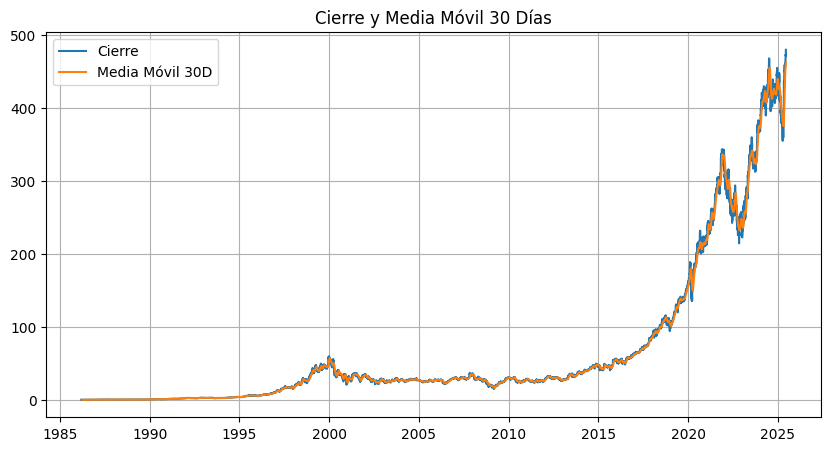

In [5]:
plt.plot(fdf.index, fdf['Cierre'], label='Cierre')
plt.plot(fdf.index, fdf['MM30'], label='Media Móvil 30D')
plt.title('Cierre y Media Móvil 30 Días')
plt.legend()
plt.show()

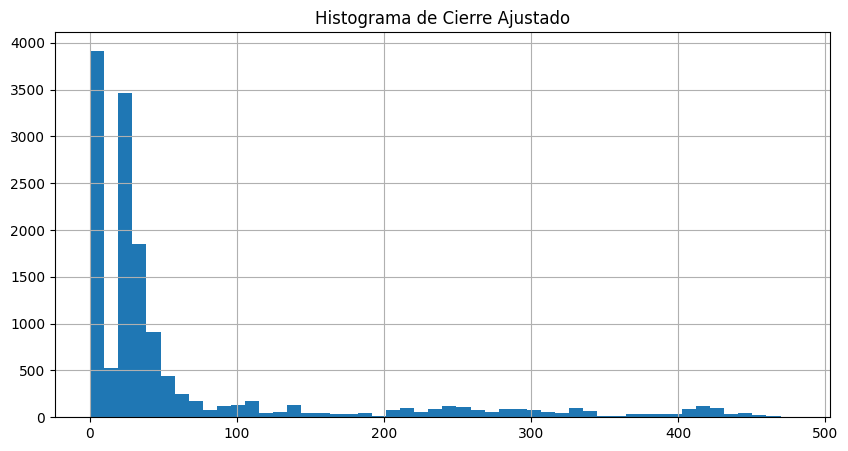

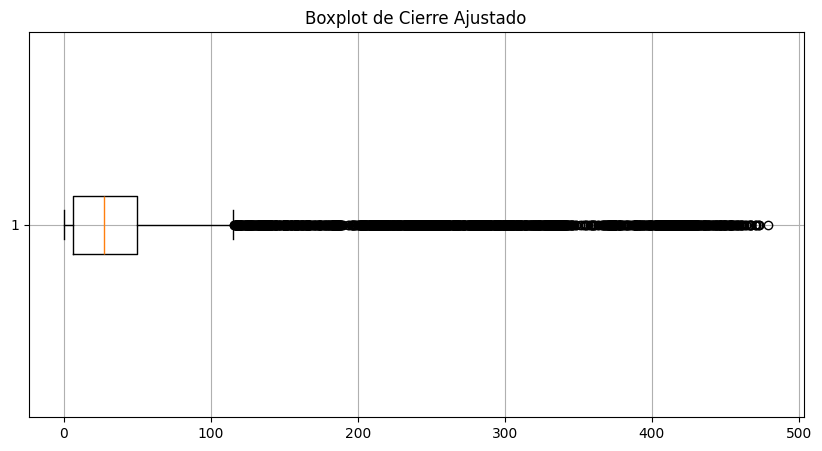

In [6]:
plt.hist(fdf['Cierre'], bins=50)
plt.title('Histograma de Cierre Ajustado')
plt.show()
plt.boxplot(fdf['Cierre'].dropna(), vert=False)
plt.title('Boxplot de Cierre Ajustado')
plt.show()

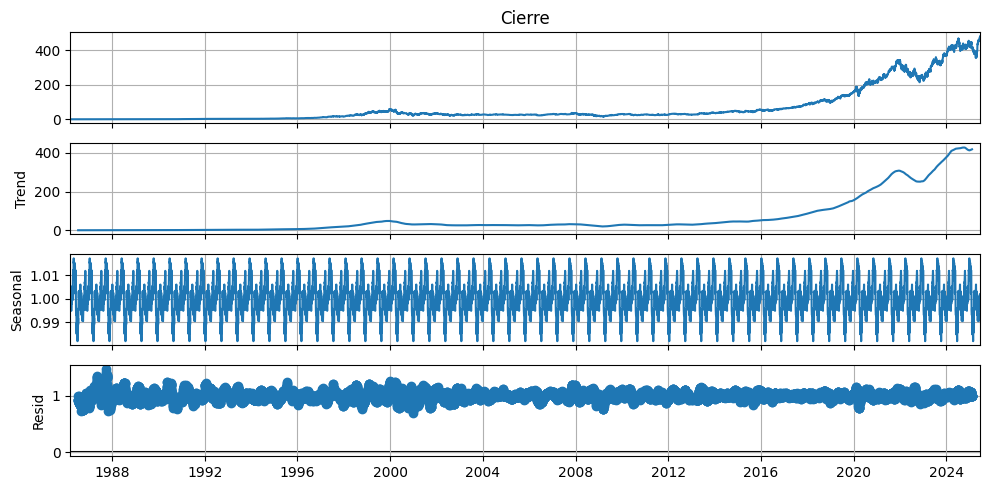

In [7]:
decomp = seasonal_decompose(fdf['Cierre'], model='multiplicative', period=252)
decomp.plot(); plt.tight_layout(); plt.show()

In [8]:
result = adfuller(fdf['Cierre'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for k,v in result[4].items(): print(f'Critical Value {k}: {v}')

ADF Statistic: 3.801044777019418
p-value: 1.0
Critical Value 1%: -3.4308075678415872
Critical Value 5%: -2.8617422244581063
Critical Value 10%: -2.5668776393253125


In [9]:
model = Modeller()
metrics = model.entrenar(fdf.reset_index().rename(columns={'fecha':'fecha','Cierre':'cerrar'}), pasos=7)
print('Métricas LSTM:')
for k,v in metrics.items(): print(f'{k}: {v}')

2025-06-12 14:47:08,756 - INFO - Iniciando Entrenamiento Del Modelo LSTM...


c:\Users\user\Downloads\proyecto-integrado-v-datos-msft-analytics\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


2025-06-12 14:50:01,478 - INFO - RMSE: 28.1462
2025-06-12 14:50:01,481 - INFO - MAE: 26.6034
2025-06-12 14:50:01,484 - INFO - MAPE: 9.06%
2025-06-12 14:50:01,485 - INFO - R²: 0.9048


Métricas LSTM:
rmse: 28.146153008398596
mae: 26.60342870472122
mape: 9.060368455281319
r2: 0.9047805032778717
r2_mayor_85: True


2025-06-12 14:50:01,527 - INFO - Realizando Predicción A 7 Días...


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
  Fecha_Predicha  prediccion
0     2025-06-13  437.165222
1     2025-06-14  415.059235
2     2025-06-15  389.590240
3     2025-06-16  361.770752
4     2025-06-17  332.724792
5     2025-06-18  303.487946
6     2025-06-19  274.990723


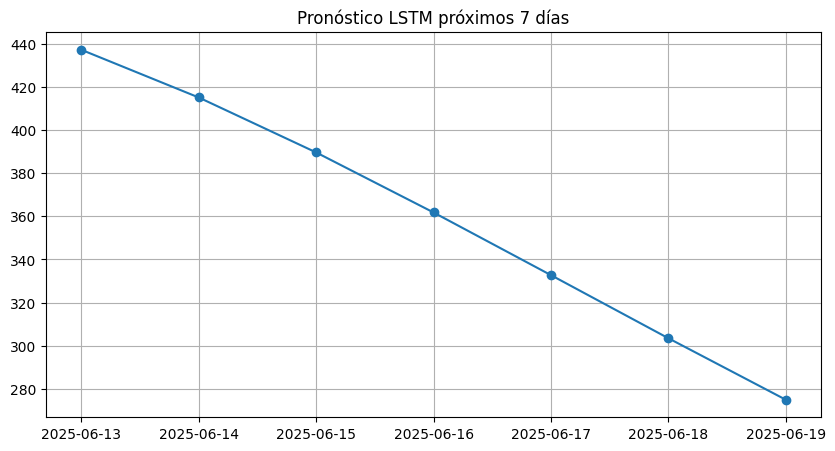

In [10]:
pred = model.predecir(fdf.reset_index().rename(columns={'fecha':'fecha','Cierre':'cerrar'}), pasos=7)
print(pred)
plt.plot(pred['Fecha_Predicha'], pred['prediccion'], marker='o')
plt.title('Pronóstico LSTM próximos 7 días')
plt.show()